# Лабораторная работа №5

ФИО:   
Группа: 

Отправлять можно следующими способами:
1. Запушить этот ноутбук в GitHub в репозиторий, где у вас лежат ноутбуки с лабами

Deadlines:
- Занятие №8 в семестре

Что необходимо сделать:  
- Обучить различные модели глубокого обучения на имеющихся данных  

---
## Читайте задание внимательно

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/1NOE0D4JQgD6LbvUqWboUI1TFj4P87ugbqUTDquxlGEI/edit?usp=sharing) необходимо узнать название своего датасета 
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1sbsjBsJ_ln0XgXCI9R6s17pvyvApgcwF?usp=sharing)
  
---
#### Теперь по пунктам, что я от вас жду:

1. **Загрузить данные** к себе и считать (read) их в переменные.  

2. **Описать постановку задачи**, что от вас хотят.  
   Какие классы, бинарная или многоклассовая классификация, пример реального применения.  
   Показать по 2–3 примера изображений на класс.

3. **Сделать предобработку данных**:  
   - Проверить битые файлы/повреждённые изображения, привести к единому размеру (например, `224×224`).  
   - Нормализовать по каналам (стандарт для ImageNet: mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)).  
   - Разделить на **train**/**val** (или **train**/**test**).  
   - Оформить данные в `Dataset`/`ImageFolder` и передать в `DataLoader`.

4. **Провести разведочный анализ данных (EDA)**:  
   - Посчитать количество изображений в каждом классе и оценить дисбаланс.  
   - Построить 1–2 гистограммы/барчарта распределения по классам.  
   - Сделать промежуточные выводы (есть ли редкие классы, артефакты, перекрытие классов и т.п.).

5. **Настроить аугментации** (минимум три): `RandomHorizontalFlip`, `RandomRotation`, `ColorJitter`, `RandomResizedCrop` и др.  
   Коротко описать, почему выбраны именно эти аугментации и как они помогают обобщению.

6. **Выбор и обучение модели**:  
   - Базовый вариант: **transfer learning** на `ResNet18`/`MobileNetV2`/`EfficientNetB0` (предобученные веса).  
   - Заменить выходной слой под число классов.  
   - Задать функцию потерь `CrossEntropyLoss`, оптимизатор (`AdamW`/`SGD`) и расписание обучения (кол-во эпох, `lr`).  
   - В процессе обучения логировать `train loss/acc` и `val loss/acc` по эпохам.  
   - Сохранить лучшую модель по `val acc`/минимальному `val loss`.

7. **Посчитать метрики качества** на **train** и **val/test** множествах:  
   - Для классификации: `Accuracy`, `Precision`, `Recall`, `F1` (macro/micro — обосновать выбор).  
   - Построить **матрицу ошибок (Confusion Matrix)**; ROC-кривые.

8. **Сравнить результаты** (если пробовали несколько моделей/настроек):  
   - Какая модель лучше справилась?  
   - Есть ли переобучение (по кривым обучения)?  
   - Какие классы путаются чаще всего и почему?  
   - Что ещё можно улучшить (аугментации, веса классов, больше данных, регуляризация, тонкая настройка `lr` и т.д.)?

9. **Визуализировать предсказания**:  
   - Показать не менее 10 изображений из валидации/теста с предсказанными и истинными классами.  
   - Пометить корректные (`Y`) и ошибочные (`N`) предсказания, сделать краткие выводы.

---

## P.S.
Просьба — делать каждое задание в отдельных ячейках с отдельными заголовками (как пункт 1 и 2 в этом ноутбуке) типа:
- Заголовок  
- Ячейка с кодом  
- Другой заголовок  
- Другая ячейка с кодом

## P.S.S.
Если у вас **многоклассовая** классификация, убедитесь, что последний слой имеет размерность `num_classes`, а для `CrossEntropyLoss` **не** требуется one-hot.  
При сильном дисбалансе рассмотрите: `class weights` в `CrossEntropyLoss`, oversampling/undersampling.


## 1. Загрузить данные

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# Путь к CSV файлу с данными
CSV_PATH = 'sports.csv'
IMAGES_ROOT = '.'  # Корневая папка, где находятся изображения (относительно CSV)

# Загружаем CSV файл
data = pd.read_csv(CSV_PATH)
print(f"Загружено строк из CSV: {len(data)}")
print(f"Колонки: {data.columns.tolist()}")
print(f"\nРаспределение по data set:")
print(data['data set'].value_counts())
print(f"\nКоличество уникальных классов: {data['labels'].nunique()}")
print(f"Классы: {sorted(data['labels'].unique())[:10]}...")  # Показываем первые 10

Загружено строк из CSV: 14493
Колонки: ['class id', 'filepaths', 'labels', 'data set']

Распределение по data set:
data set
train    13493
test       500
valid      500
Name: count, dtype: int64

Количество уникальных классов: 100
Классы: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling']...


## 2. Описать постановку задачи

Тип задачи: Многоклассовая классификация
Количество классов: 100
Первые 10 классов: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling']...


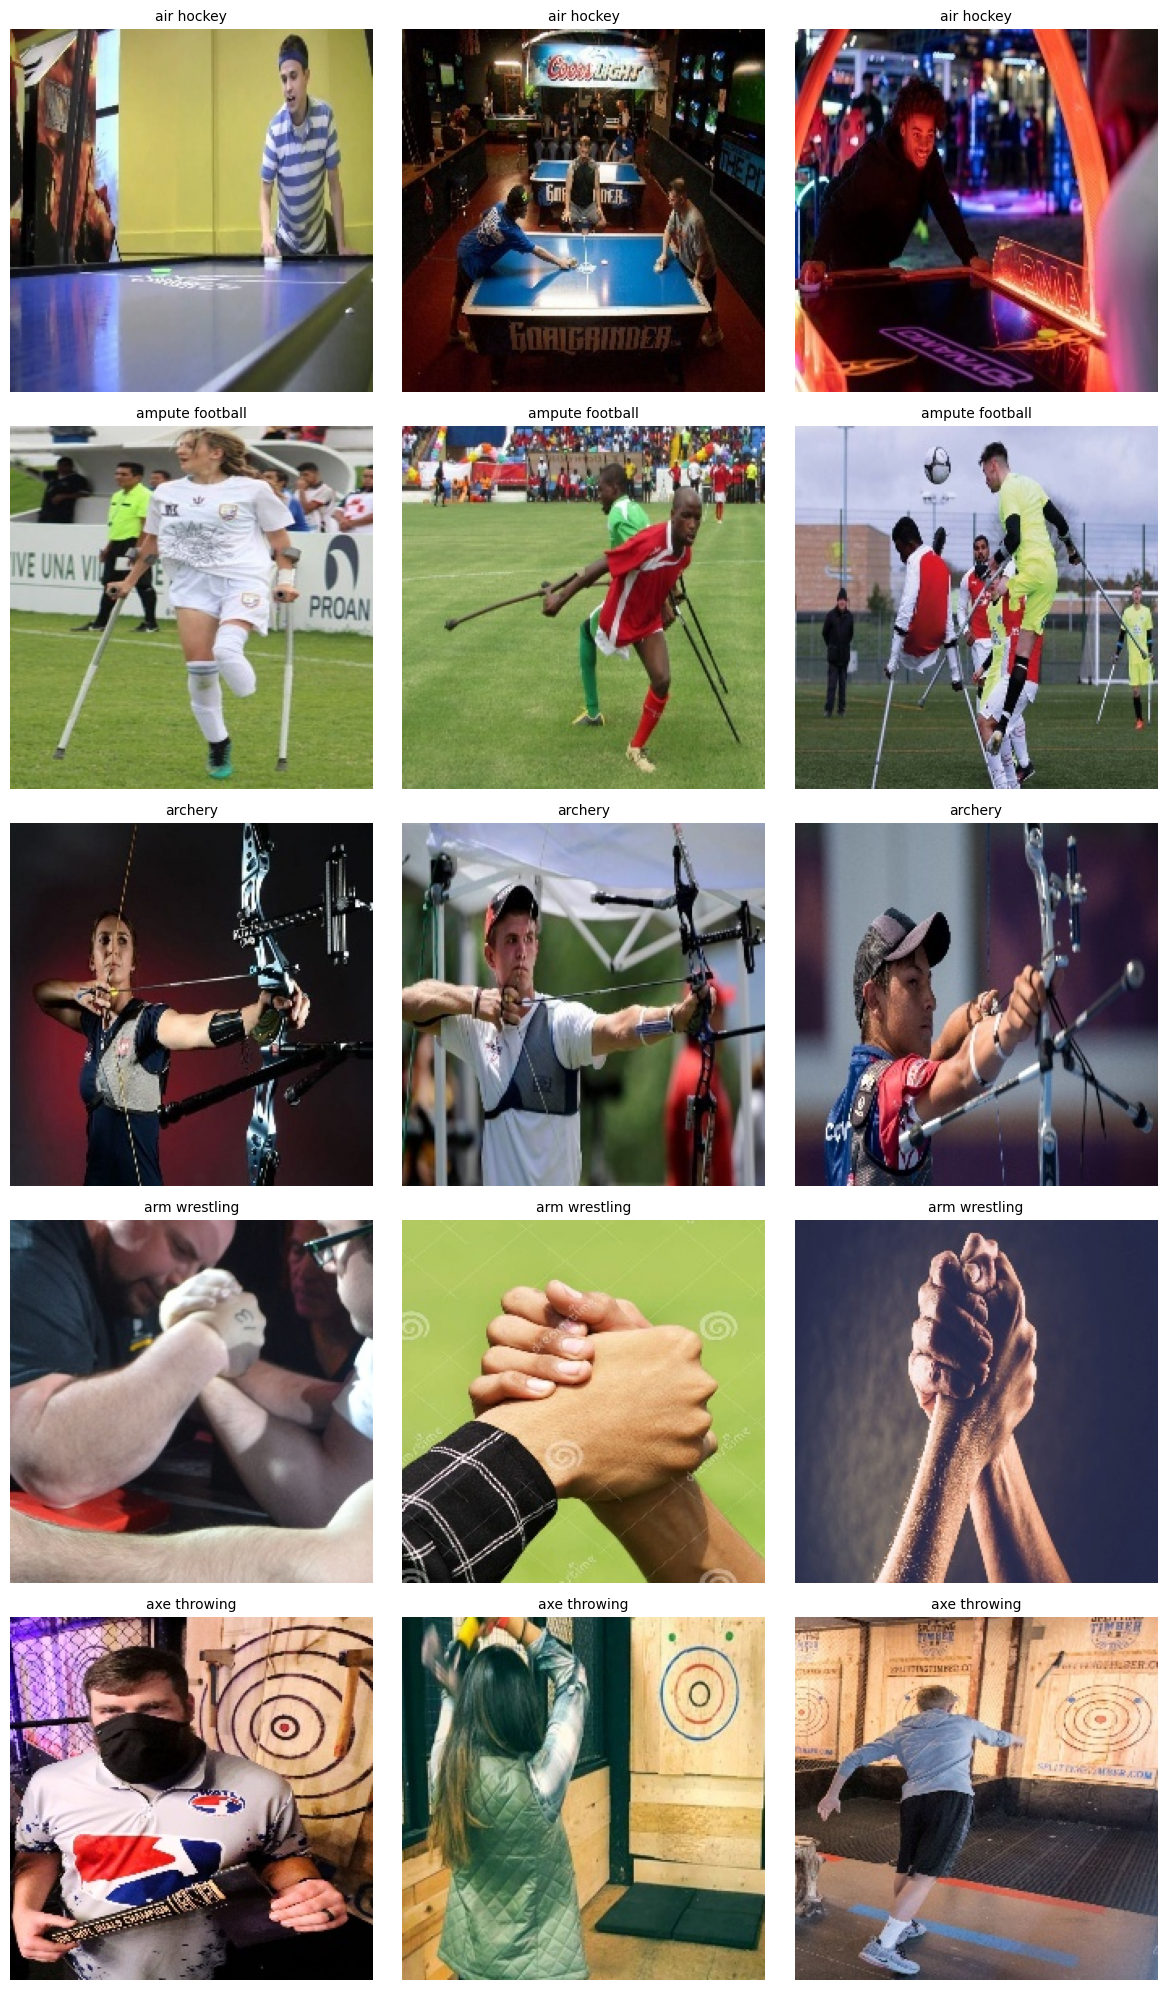


Пример реального применения:
Классификация спортивных изображений может применяться в:
- Автоматическая категоризация спортивного контента
- Системы поиска и фильтрации изображений
- Анализ спортивных событий и статистики
- Медиа-библиотеки и архивы спортивных фотографий


In [2]:
# Определяем количество классов и тип задачи
classes = sorted(data['labels'].unique())
num_classes = len(classes)

# Определяем тип задачи
if num_classes == 2:
    task_type = "Бинарная классификация"
else:
    task_type = "Многоклассовая классификация"

print(f"Тип задачи: {task_type}")
print(f"Количество классов: {num_classes}")
print(f"Первые 10 классов: {classes[:10]}...")

# Показываем примеры изображений для нескольких классов (берем первые 5 классов)
sample_classes = classes[:5]
fig, axes = plt.subplots(len(sample_classes), 3, figsize=(12, 4*len(sample_classes)))

for idx, class_name in enumerate(sample_classes):
    class_images = data[data['labels'] == class_name]['filepaths'].head(3).tolist()
    
    for i, img_path in enumerate(class_images):
        full_path = os.path.join(IMAGES_ROOT, img_path)
        try:
            img = Image.open(full_path)
            axes[idx, i].imshow(img)
            axes[idx, i].set_title(f'{class_name}', fontsize=10)
            axes[idx, i].axis('off')
        except Exception as e:
            axes[idx, i].text(0.5, 0.5, f'Ошибка\nзагрузки', 
                            ha='center', va='center', transform=axes[idx, i].transAxes)
            axes[idx, i].axis('off')

plt.tight_layout()
plt.show()

print("\nПример реального применения:")
print("Классификация спортивных изображений может применяться в:")
print("- Автоматическая категоризация спортивного контента")
print("- Системы поиска и фильтрации изображений")
print("- Анализ спортивных событий и статистики")
print("- Медиа-библиотеки и архивы спортивных фотографий")


## 3. Предобработка данных

In [3]:
# Кастомный Dataset класс для работы с CSV
class SportsDataset(Dataset):
    def __init__(self, dataframe, images_root, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.images_root = images_root
        self.transform = transform
        self.classes = sorted(dataframe['labels'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.images_root, row['filepaths'])
        label = row['labels']
        label_idx = self.class_to_idx[label]
        
        # Пытаемся загрузить изображение несколько раз
        max_retries = 3
        for attempt in range(max_retries):
            try:
                img = Image.open(img_path).convert('RGB')
                break
            except Exception as e:
                if attempt == max_retries - 1:
                    # Если не удалось загрузить, создаем черное изображение
                    img = Image.new('RGB', (224, 224), color='black')
                    # Не выводим ошибку для каждого изображения, чтобы не засорять вывод
                else:
                    continue
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_idx

# Функция для проверки битых изображений
def check_corrupted_images(dataframe, images_root, sample_size=100):
    """Проверяет наличие поврежденных изображений (выборочно)"""
    corrupted = []
    sample_data = dataframe.sample(min(sample_size, len(dataframe)))
    
    for idx, row in sample_data.iterrows():
        img_path = os.path.join(images_root, row['filepaths'])
        try:
            img = Image.open(img_path)
            img.verify()
        except Exception as e:
            corrupted.append(img_path)
    
    return corrupted

# Проверяем битые файлы (выборочно)
print("Проверка на поврежденные изображения (выборочно)...")
corrupted = check_corrupted_images(data, IMAGES_ROOT, sample_size=500)
if corrupted:
    print(f"Найдено {len(corrupted)} поврежденных изображений в выборке")
    print("Примеры:", corrupted[:3])
else:
    print("Поврежденных изображений не найдено в выборке")

# Параметры предобработки
IMAGE_SIZE = 224
# Уменьшаем batch size для более стабильной работы на CPU
BATCH_SIZE = 16
# На Windows num_workers должен быть 0, иначе могут быть проблемы с загрузкой
NUM_WORKERS = 0

# Нормализация ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Трансформации для валидации (без аугментаций)
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Разделяем данные на train и val
# Используем колонку 'data set' для разделения
train_data = data[data['data set'] == 'train'].copy()
val_data = data[data['data set'] == 'valid'].copy()
test_data = data[data['data set'] == 'test'].copy()

print(f"\nРазмер обучающей выборки: {len(train_data)}")
print(f"Размер валидационной выборки: {len(val_data)}")
print(f"Размер тестовой выборки: {len(test_data)}")
print(f"Всего изображений: {len(data)}")

# Создаем датасеты
train_dataset = SportsDataset(train_data, IMAGES_ROOT, transform=val_transform)
val_dataset = SportsDataset(val_data, IMAGES_ROOT, transform=val_transform)
test_dataset = SportsDataset(test_data, IMAGES_ROOT, transform=val_transform)

# Создаем DataLoader'ы
# На Windows используем num_workers=0 для избежания проблем с загрузкой
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)

print("Предобработка данных завершена!")


Проверка на поврежденные изображения (выборочно)...
Поврежденных изображений не найдено в выборке

Размер обучающей выборки: 13493
Размер валидационной выборки: 500
Размер тестовой выборки: 500
Всего изображений: 14493
Предобработка данных завершена!


## 4. Разведочный анализ данных (EDA)


In [ ]:
# Проверяем, что данные загружены
if 'data' not in globals() or 'data' not in locals():
    print("⚠️ ВНИМАНИЕ: Переменная 'data' не определена!")
    print("📝 Решение: Сначала выполните ячейку 2 (Cell 2) для загрузки данных.")
    print("   В Jupyter: выберите ячейку 2 и нажмите Shift+Enter или Run")
    print("   Или выполните все ячейки: Kernel → Restart & Run All")
    raise NameError("Переменная 'data' не определена! Сначала выполните ячейку 2 для загрузки данных.")

# Подсчитываем количество изображений в каждом классе
class_counts = data['labels'].value_counts().to_dict()
classes_list = sorted(class_counts.keys())
counts_list = [class_counts[cls] for cls in classes_list]

# Визуализация распределения классов
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Барчарт (показываем топ-20 классов для читаемости)
top_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)[:20]
top_classes_names = [cls[0] for cls in top_classes]
top_classes_counts = [cls[1] for cls in top_classes]

axes[0].bar(range(len(top_classes_names)), top_classes_counts, color='skyblue', edgecolor='black')
axes[0].set_title('Распределение изображений по классам (топ-20)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Классы', fontsize=12)
axes[0].set_ylabel('Количество изображений', fontsize=12)
axes[0].set_xticks(range(len(top_classes_names)))
axes[0].set_xticklabels(top_classes_names, rotation=45, ha='right')
for i, v in enumerate(top_classes_counts):
    axes[0].text(i, v, str(v), ha='center', va='bottom', fontsize=8)

# Гистограмма
axes[1].hist(counts_list, bins=min(30, len(classes_list)), color='lightcoral', edgecolor='black')
axes[1].set_title('Гистограмма распределения размеров классов', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Количество изображений в классе', fontsize=12)
axes[1].set_ylabel('Частота', fontsize=12)

plt.tight_layout()
plt.show()

# Статистика
print("Статистика по классам:")
print("-" * 50)
total_images = sum(counts_list)
for class_name, count in list(class_counts.items())[:10]:  # Показываем первые 10
    percentage = (count / total_images) * 100
    print(f"{class_name}: {count} изображений ({percentage:.2f}%)")
if len(class_counts) > 10:
    print(f"... и еще {len(class_counts) - 10} классов")

print("-" * 50)
print(f"Всего изображений: {total_images}")
print(f"Среднее на класс: {np.mean(counts_list):.2f}")
print(f"Медиана: {np.median(counts_list):.2f}")
print(f"Мин: {min(counts_list)}, Макс: {max(counts_list)}")

# Оценка дисбаланса
max_count = max(counts_list)
min_count = min(counts_list)
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"\nКоэффициент дисбаланса (макс/мин): {imbalance_ratio:.2f}")

if imbalance_ratio > 3:
    print("⚠️ ВНИМАНИЕ: Обнаружен значительный дисбаланс классов!")
    print("Рекомендуется использовать class weights или oversampling")
elif imbalance_ratio > 2:
    print("⚠️ Обнаружен умеренный дисбаланс классов")
else:
    print("✓ Классы сбалансированы")

# Выводы
print("\nПромежуточные выводы:")
print("- Проверено распределение данных по классам")
if imbalance_ratio > 2:
    print("- Обнаружен дисбаланс классов, что может потребовать специальных мер")
rare_classes = [cls for cls, cnt in class_counts.items() if cnt < total_images * 0.01]
if rare_classes:
    print(f"- Редкие классы (<1% данных): {len(rare_classes)} классов")
else:
    print("- Редких классов не обнаружено")


## 5. Настройка аугментаций


Аугментации настроены:
1. RandomResizedCrop - помогает модели быть устойчивой к различным масштабам объектов
2. RandomHorizontalFlip - увеличивает разнообразие данных, особенно полезно для симметричных объектов
3. RandomRotation - делает модель устойчивой к поворотам изображений
4. ColorJitter - помогает модели быть устойчивой к изменениям освещения и цветов


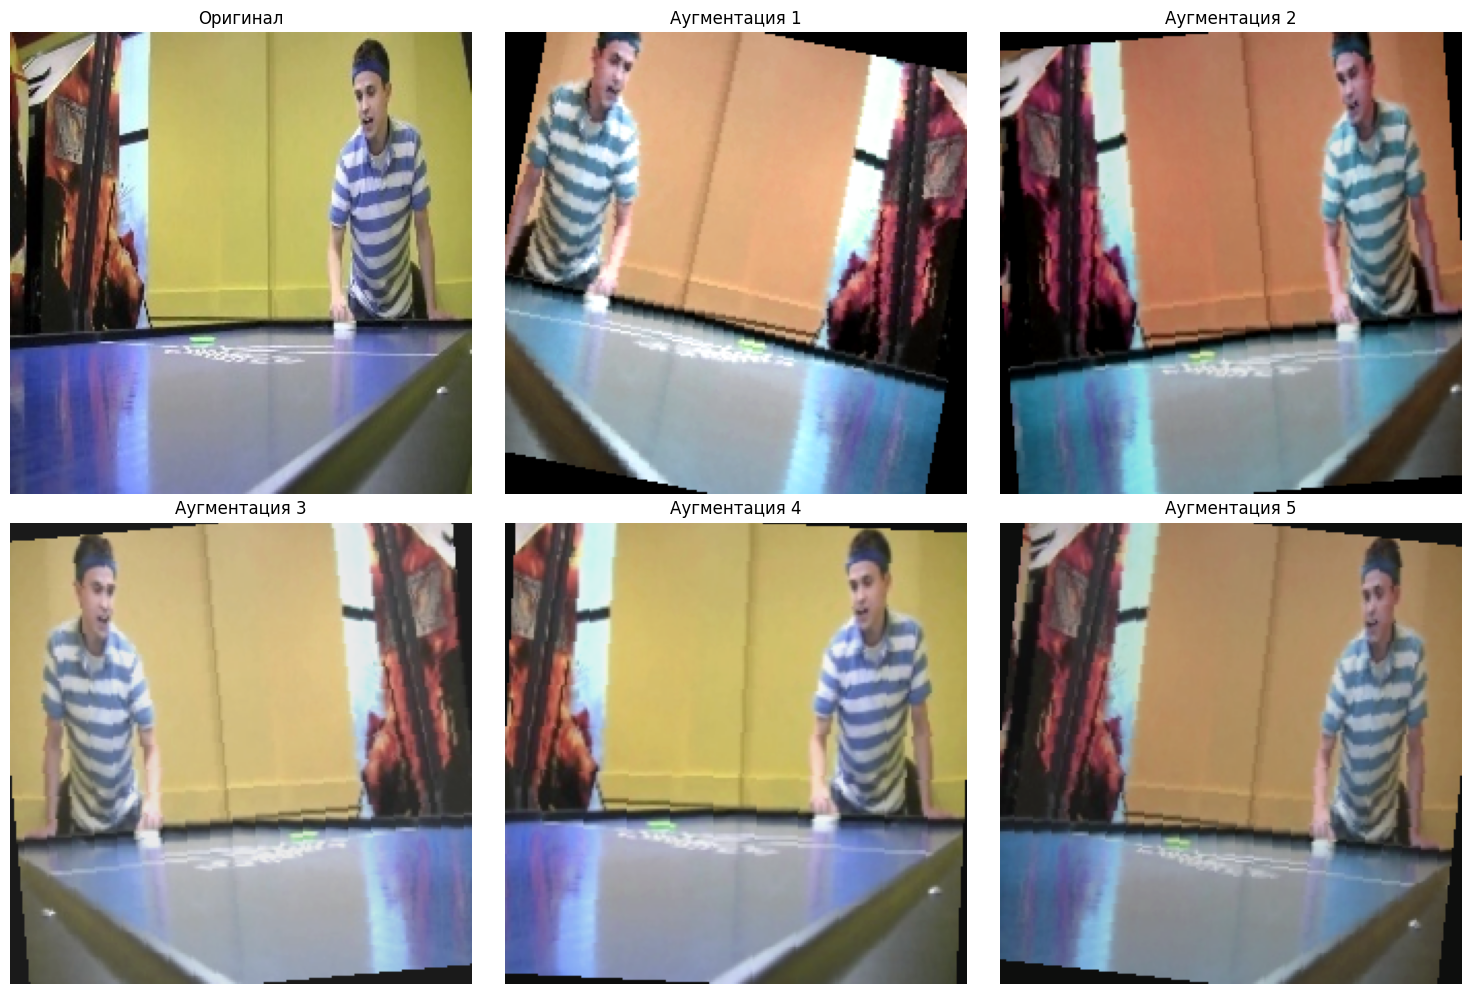

In [5]:
# Аугментации для обучающей выборки
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Сначала увеличиваем размер
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),  # Случайный кроп с масштабированием
    transforms.RandomHorizontalFlip(p=0.5),  # Горизонтальное отражение
    transforms.RandomRotation(degrees=15),  # Поворот на ±15 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Изменение цвета
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Создаем train_dataset с аугментациями
train_dataset_augmented = SportsDataset(train_data, IMAGES_ROOT, transform=train_transform)

# Создаем DataLoader для обучения
# На Windows используем num_workers=0 для избежания проблем с загрузкой
train_loader = DataLoader(train_dataset_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=False)

print("Аугментации настроены:")
print("1. RandomResizedCrop - помогает модели быть устойчивой к различным масштабам объектов")
print("2. RandomHorizontalFlip - увеличивает разнообразие данных, особенно полезно для симметричных объектов")
print("3. RandomRotation - делает модель устойчивой к поворотам изображений")
print("4. ColorJitter - помогает модели быть устойчивой к изменениям освещения и цветов")

# Визуализация аугментаций
sample_img_path = None
for class_name in classes[:5]:  # Берем первый доступный класс
    class_images = data[data['labels'] == class_name]['filepaths']
    if len(class_images) > 0:
        sample_img_path = os.path.join(IMAGES_ROOT, class_images.iloc[0])
        break

if sample_img_path and os.path.exists(sample_img_path):
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        original_img = Image.open(sample_img_path)
        
        for i in range(6):
            row, col = i // 3, i % 3
            if i == 0:
                axes[row, col].imshow(original_img)
                axes[row, col].set_title('Оригинал')
            else:
                # Применяем аугментации
                aug_img = train_transform(original_img)
                # Денормализуем для визуализации
                aug_img_np = aug_img.permute(1, 2, 0).numpy()
                aug_img_np = aug_img_np * np.array(std) + np.array(mean)
                aug_img_np = np.clip(aug_img_np, 0, 1)
                axes[row, col].imshow(aug_img_np)
                axes[row, col].set_title(f'Аугментация {i}')
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()


## 6. Выбор и обучение модели


In [6]:
# Определяем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

# Функция для создания модели с transfer learning
def create_model(model_name='resnet18', num_classes=None):
    """Создает модель с предобученными весами"""
    if num_classes is None:
        num_classes = len(classes) if 'classes' in globals() else 2
    
    if model_name == 'resnet18':
        model = models.resnet18(weights='IMAGENET1K_V1')
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    elif model_name == 'mobilenetv2':
        model = models.mobilenet_v2(weights='IMAGENET1K_V1')
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)
    elif model_name == 'efficientnetb0':
        model = models.efficientnet_b0(weights='IMAGENET1K_V1')
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)
    else:
        raise ValueError(f"Неизвестная модель: {model_name}")
    
    return model

# Создаем модель
num_classes = len(classes)
model = create_model('resnet18', num_classes)
model = model.to(device)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Параметры обучения
# Для быстрого теста можно уменьшить количество эпох
# Для полного обучения используйте 15-20 эпох
num_epochs = 15
# Если хотите быстро протестировать, раскомментируйте следующую строку:
# num_epochs = 3

best_val_acc = 0.0
best_model_state = None

# История обучения
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print(f"Модель: ResNet18")
print(f"Количество классов: {num_classes}")
print(f"Количество эпох: {num_epochs}")
print(f"Начальный learning rate: 0.001")
print(f"Оптимизатор: AdamW")
print(f"Функция потерь: CrossEntropyLoss")
print("\nНачинаем обучение...")


Используемое устройство: cuda
Модель: ResNet18
Количество классов: 100
Количество эпох: 15
Начальный learning rate: 0.001
Оптимизатор: AdamW
Функция потерь: CrossEntropyLoss

Начинаем обучение...


In [7]:
# Функции для обучения и валидации
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Добавляем счетчик для отслеживания прогресса
    batch_count = 0
    total_batches = len(loader)
    
    for inputs, labels in loader:
        try:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            batch_count += 1
            # Показываем прогресс каждые 50 батчей
            if batch_count % 50 == 0:
                print(f"  Обработано батчей: {batch_count}/{total_batches} ({100*batch_count/total_batches:.1f}%)")
        except Exception as e:
            print(f"Ошибка при обработке батча: {e}")
            continue
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            try:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            except Exception as e:
                print(f"Ошибка при валидации батча: {e}")
                continue
    
    epoch_loss = running_loss / len(loader) if len(loader) > 0 else 0.0
    epoch_acc = 100 * correct / total if total > 0 else 0.0
    return epoch_loss, epoch_acc

# Обучение модели
if os.path.exists(IMAGES_ROOT) and 'model' in globals() and model is not None:
    for epoch in range(num_epochs):
        # Обучение
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Валидация
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Обновление learning rate
        scheduler.step()
        
        # Сохранение истории
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Сохранение лучшей модели
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'LR: {scheduler.get_last_lr()[0]:.6f}')
        print('-' * 50)
    
    # Загружаем лучшую модель
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'\nЛучшая валидационная точность: {best_val_acc:.2f}%')
        
        # Сохраняем модель
        torch.save(best_model_state, 'best_model.pth')
        print('Модель сохранена в best_model.pth')
    else:
        print('\nПредупреждение: Модель не была сохранена, так как обучение не завершилось')
else:
    print("Сначала укажите правильный путь к датасету и создайте модель")


  Обработано батчей: 50/844 (5.9%)
  Обработано батчей: 100/844 (11.8%)
  Обработано батчей: 150/844 (17.8%)
  Обработано батчей: 200/844 (23.7%)
  Обработано батчей: 250/844 (29.6%)
  Обработано батчей: 300/844 (35.5%)
  Обработано батчей: 350/844 (41.5%)
  Обработано батчей: 400/844 (47.4%)
  Обработано батчей: 450/844 (53.3%)
  Обработано батчей: 500/844 (59.2%)
  Обработано батчей: 550/844 (65.2%)
  Обработано батчей: 600/844 (71.1%)
  Обработано батчей: 650/844 (77.0%)
  Обработано батчей: 700/844 (82.9%)
  Обработано батчей: 750/844 (88.9%)
  Обработано батчей: 800/844 (94.8%)
Epoch [1/15]
Train Loss: 3.0914, Train Acc: 23.98%
Val Loss: 2.5361, Val Acc: 38.00%
LR: 0.001000
--------------------------------------------------
  Обработано батчей: 50/844 (5.9%)
  Обработано батчей: 100/844 (11.8%)
  Обработано батчей: 150/844 (17.8%)
  Обработано батчей: 200/844 (23.7%)
  Обработано батчей: 250/844 (29.6%)
  Обработано батчей: 300/844 (35.5%)
  Обработано батчей: 350/844 (41.5%)
  Об

## 7. Метрики качества


In [8]:
def calculate_metrics(model, loader, device, classes):
    """Вычисляет метрики качества модели"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Precision, Recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    
    # Micro average
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='micro', zero_division=0
    )
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        'accuracy': accuracy,
        'precision_macro': precision,
        'recall_macro': recall,
        'f1_macro': f1,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_micro': f1_micro,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

# Вычисляем метрики
if os.path.exists(IMAGES_ROOT) and 'model' in globals() and model is not None:
    print("Вычисление метрик на обучающей выборке...")
    train_metrics = calculate_metrics(model, train_loader, device, classes)
    
    print("\nВычисление метрик на валидационной выборке...")
    val_metrics = calculate_metrics(model, val_loader, device, classes)
    
    # Выводим результаты
    print("\n" + "="*60)
    print("МЕТРИКИ КАЧЕСТВА")
    print("="*60)
    print("\nОбучающая выборка:")
    print(f"  Accuracy: {train_metrics['accuracy']:.4f}")
    print(f"  Precision (macro): {train_metrics['precision_macro']:.4f}")
    print(f"  Recall (macro): {train_metrics['recall_macro']:.4f}")
    print(f"  F1-score (macro): {train_metrics['f1_macro']:.4f}")
    print(f"  Precision (micro): {train_metrics['precision_micro']:.4f}")
    print(f"  Recall (micro): {train_metrics['recall_micro']:.4f}")
    print(f"  F1-score (micro): {train_metrics['f1_micro']:.4f}")
    
    print("\nВалидационная выборка:")
    print(f"  Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"  Precision (macro): {val_metrics['precision_macro']:.4f}")
    print(f"  Recall (macro): {val_metrics['recall_macro']:.4f}")
    print(f"  F1-score (macro): {val_metrics['f1_macro']:.4f}")
    print(f"  Precision (micro): {val_metrics['precision_micro']:.4f}")
    print(f"  Recall (micro): {val_metrics['recall_micro']:.4f}")
    print(f"  F1-score (micro): {val_metrics['f1_micro']:.4f}")
    
    print("\nОбоснование выбора метрик:")
    print("  - Macro average: учитывает дисбаланс классов, дает равный вес каждому классу")
    print("  - Micro average: глобальная метрика, учитывает общее количество TP, FP, FN")
    if num_classes > 2:
        print("  - Для многоклассовой задачи macro более информативен при дисбалансе")
    else:
        print("  - Для бинарной задачи macro и micro совпадают")
else:
    print("Сначала обучите модель")


Вычисление метрик на обучающей выборке...

Вычисление метрик на валидационной выборке...

МЕТРИКИ КАЧЕСТВА

Обучающая выборка:
  Accuracy: 0.9817
  Precision (macro): 0.9816
  Recall (macro): 0.9815
  F1-score (macro): 0.9814
  Precision (micro): 0.9817
  Recall (micro): 0.9817
  F1-score (micro): 0.9817

Валидационная выборка:
  Accuracy: 0.8760
  Precision (macro): 0.9003
  Recall (macro): 0.8760
  F1-score (macro): 0.8733
  Precision (micro): 0.8760
  Recall (micro): 0.8760
  F1-score (micro): 0.8760

Обоснование выбора метрик:
  - Macro average: учитывает дисбаланс классов, дает равный вес каждому классу
  - Micro average: глобальная метрика, учитывает общее количество TP, FP, FN
  - Для многоклассовой задачи macro более информативен при дисбалансе


Внимание: Классов слишком много (100). Показываем только топ-20.


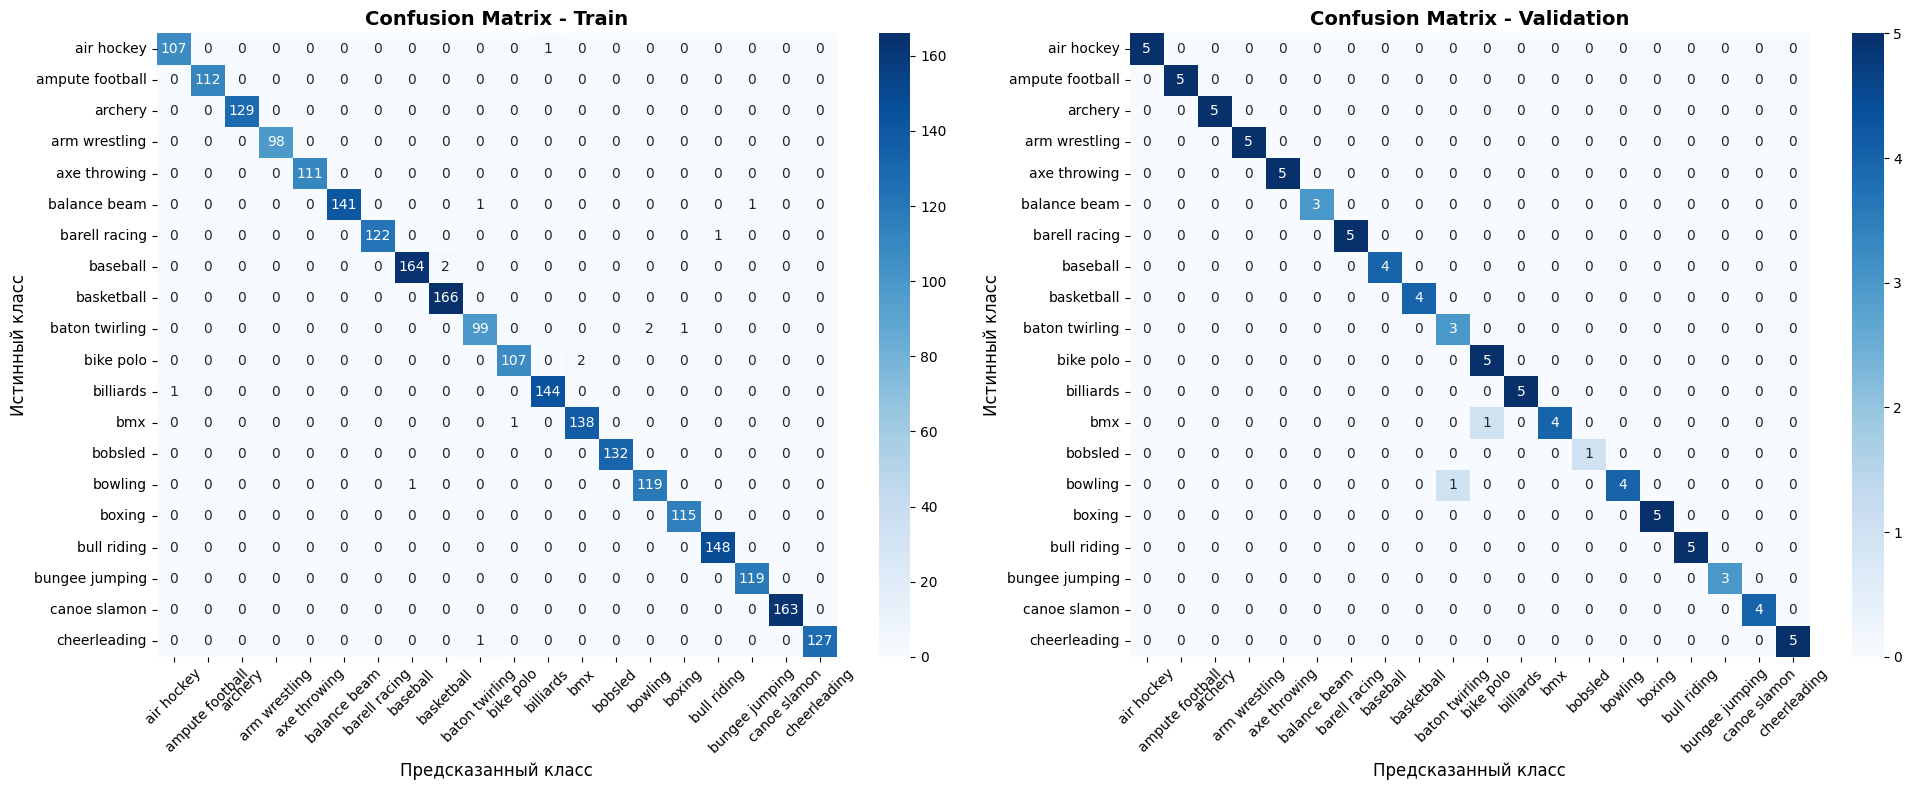

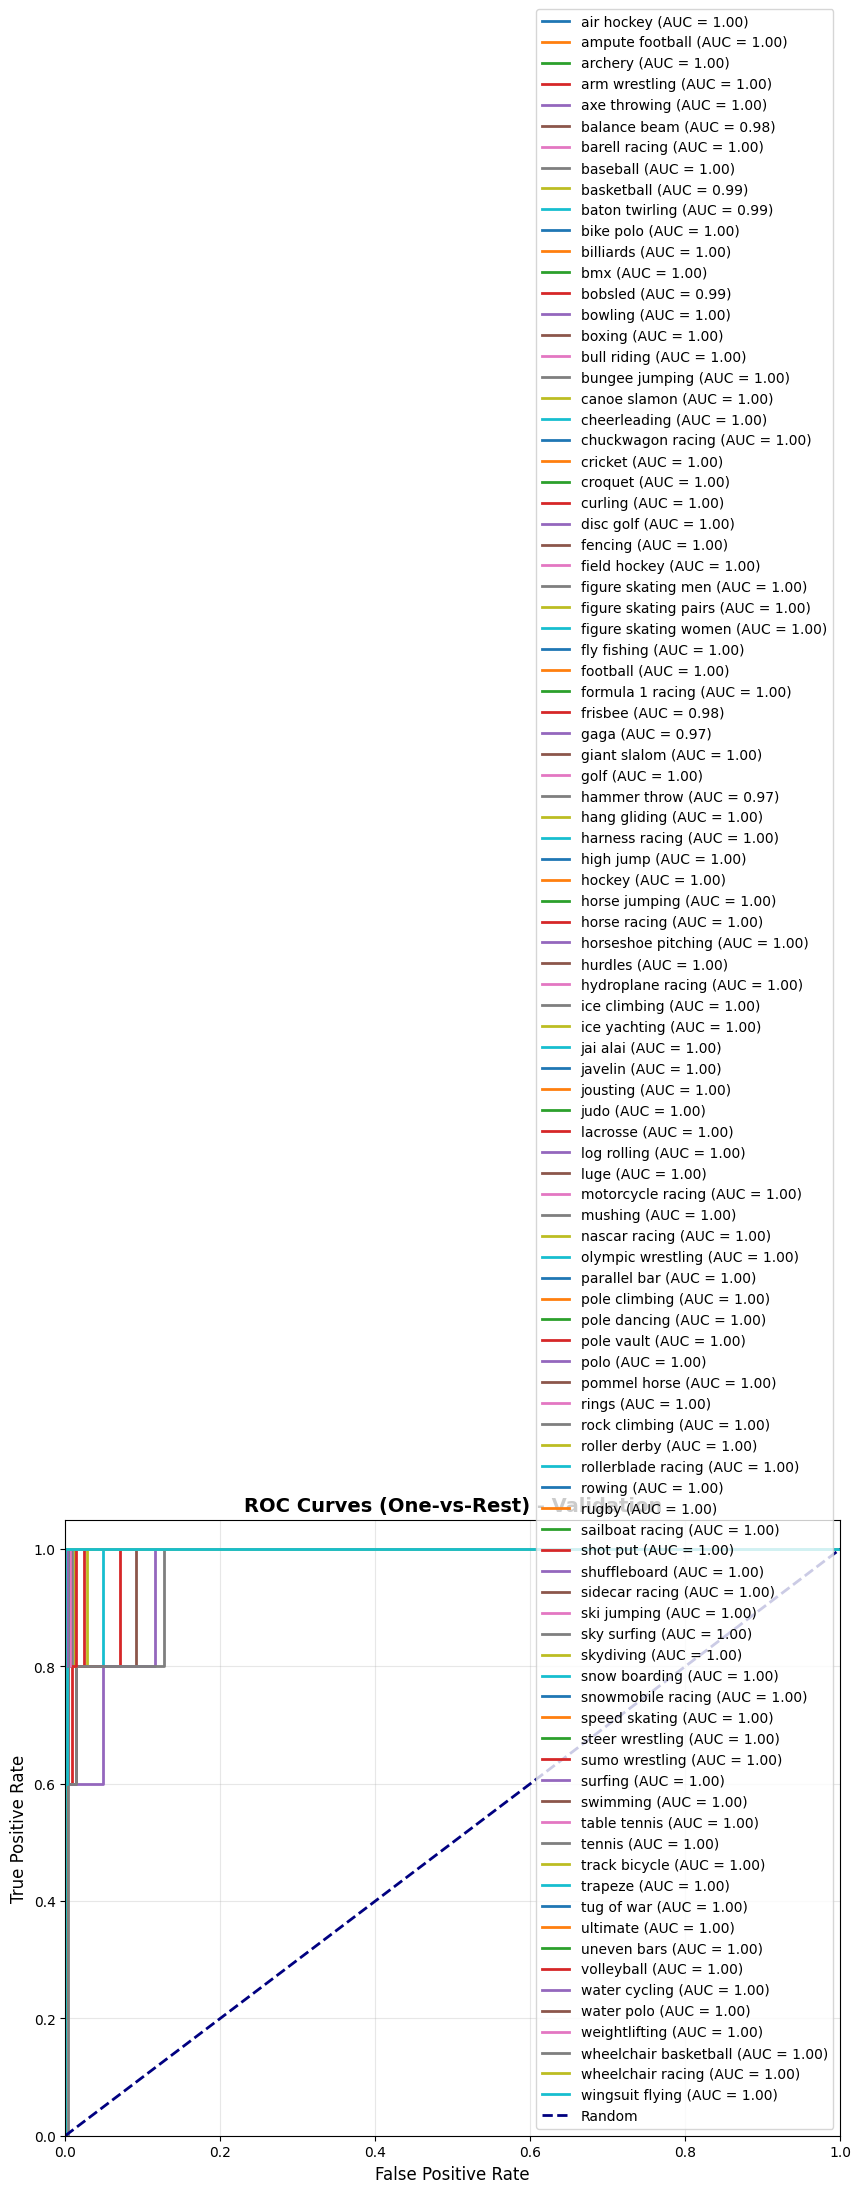

In [9]:
# Визуализация матрицы ошибок
if 'val_metrics' in globals() and 'train_metrics' in globals() and val_metrics is not None and train_metrics is not None:
    # Используем классы из датасета
    dataset_classes = val_dataset.classes
    
    # Для confusion matrix показываем только топ-20 классов для читаемости
    # или все, если классов меньше 20
    if len(dataset_classes) > 20:
        print(f"Внимание: Классов слишком много ({len(dataset_classes)}). Показываем только топ-20.")
        # Берем топ-20 классов по количеству изображений в валидации
        class_counts_val = val_data['labels'].value_counts()
        top_classes = class_counts_val.head(20).index.tolist()
        top_classes_idx = [dataset_classes.index(cls) for cls in top_classes if cls in dataset_classes]
        # Создаем уменьшенную матрицу
        cm_train_small = train_metrics['confusion_matrix'][np.ix_(top_classes_idx, top_classes_idx)]
        cm_val_small = val_metrics['confusion_matrix'][np.ix_(top_classes_idx, top_classes_idx)]
        labels_small = [dataset_classes[i] for i in top_classes_idx]
        
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        sns.heatmap(cm_train_small, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels_small, yticklabels=labels_small, ax=axes[0])
        sns.heatmap(cm_val_small, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels_small, yticklabels=labels_small, ax=axes[1])
    else:
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        # Матрица ошибок для train
        sns.heatmap(train_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                    xticklabels=dataset_classes, yticklabels=dataset_classes, ax=axes[0])
        # Матрица ошибок для val
        sns.heatmap(val_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                    xticklabels=dataset_classes, yticklabels=dataset_classes, ax=axes[1])
    
    axes[0].set_title('Confusion Matrix - Train', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Истинный класс', fontsize=12)
    axes[0].set_xlabel('Предсказанный класс', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].tick_params(axis='y', rotation=0)
    
    axes[1].set_title('Confusion Matrix - Validation', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Истинный класс', fontsize=12)
    axes[1].set_xlabel('Предсказанный класс', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # ROC-кривые (для бинарной классификации или one-vs-rest для многоклассовой)
    if num_classes == 2:
        # Бинарная классификация
        fpr, tpr, _ = roc_curve(val_metrics['labels'], val_metrics['probabilities'][:, 1])
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curve - Validation', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        # Многоклассовая классификация - one-vs-rest
        y_test_bin = label_binarize(val_metrics['labels'], classes=list(range(num_classes)))
        
        plt.figure(figsize=(10, 8))
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], val_metrics['probabilities'][:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{val_dataset.classes[i]} (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves (One-vs-Rest) - Validation', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
else:
    print("Сначала обучите модель и вычислите метрики")


## 8. Сравнение результатов и анализ


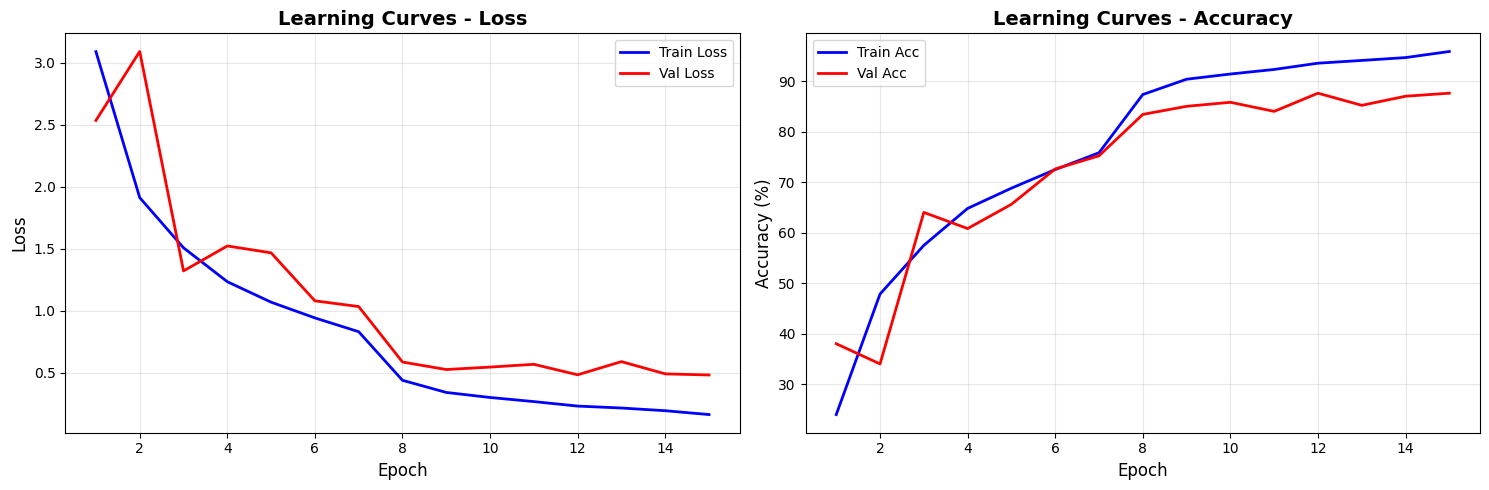

АНАЛИЗ РЕЗУЛЬТАТОВ

Финальная точность на train: 95.86%
Финальная точность на val: 87.60%
Разница (train - val): 8.26%

⚠️ Небольшое переобучение, но в пределах нормы

Анализ путающихся классов:
------------------------------------------------------------
balance beam → parallel bar: 1 случаев (20.0%)
balance beam → uneven bars: 1 случаев (20.0%)
baseball → football: 1 случаев (20.0%)
basketball → hurdles: 1 случаев (20.0%)
baton twirling → javelin: 1 случаев (20.0%)
baton twirling → tennis: 1 случаев (20.0%)
bmx → bike polo: 1 случаев (20.0%)
bobsled → formula 1 racing: 1 случаев (20.0%)
bobsled → hockey: 1 случаев (20.0%)
bobsled → hurdles: 1 случаев (20.0%)
bobsled → luge: 1 случаев (20.0%)
bowling → baton twirling: 1 случаев (20.0%)
bungee jumping → rock climbing: 1 случаев (20.0%)
bungee jumping → trapeze: 1 случаев (20.0%)
canoe slamon → javelin: 1 случаев (20.0%)
figure skating men → figure skating pairs: 1 случаев (20.0%)
fly fishing → cricket: 1 случаев (20.0%)
football → lacr

In [10]:
# Визуализация кривых обучения
if 'history' in locals() and len(history['train_loss']) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_title('Learning Curves - Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[1].set_title('Learning Curves - Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Анализ переобучения
    print("="*60)
    print("АНАЛИЗ РЕЗУЛЬТАТОВ")
    print("="*60)
    
    final_train_acc = history['train_acc'][-1]
    final_val_acc = history['val_acc'][-1]
    gap = final_train_acc - final_val_acc
    
    print(f"\nФинальная точность на train: {final_train_acc:.2f}%")
    print(f"Финальная точность на val: {final_val_acc:.2f}%")
    print(f"Разница (train - val): {gap:.2f}%")
    
    if gap > 10:
        print("\n⚠️ Обнаружено переобучение (overfitting)!")
        print("   Рекомендации:")
        print("   - Увеличить регуляризацию (dropout, weight decay)")
        print("   - Усилить аугментации")
        print("   - Уменьшить learning rate")
        print("   - Ранняя остановка (early stopping)")
    elif gap < 2:
        print("\n✓ Модель хорошо обобщается, переобучения не наблюдается")
    else:
        print("\n⚠️ Небольшое переобучение, но в пределах нормы")
    
    # Анализ путающихся классов
    if 'val_metrics' in globals() and val_metrics is not None:
        cm = val_metrics['confusion_matrix']
        print("\nАнализ путающихся классов:")
        print("-" * 60)
        
        for i in range(num_classes):
            for j in range(num_classes):
                if i != j and cm[i, j] > 0:
                    percentage = (cm[i, j] / cm[i].sum()) * 100
                    if percentage > 5:  # Показываем только значимые ошибки
                        print(f"{val_dataset.classes[i]} → {val_dataset.classes[j]}: {cm[i, j]} случаев ({percentage:.1f}%)")
        
        # Классы с наибольшим количеством ошибок
        errors_per_class = {}
        for i in range(num_classes):
            total = cm[i].sum()
            correct = cm[i, i]
            errors = total - correct
            errors_per_class[val_dataset.classes[i]] = errors
        
        worst_class = max(errors_per_class, key=errors_per_class.get)
        print(f"\nКласс с наибольшим количеством ошибок: {worst_class} ({errors_per_class[worst_class]} ошибок)")
    
    print("\nЧто можно улучшить:")
    print("1. Попробовать другие архитектуры (MobileNetV2, EfficientNetB0)")
    print("2. Использовать более агрессивные аугментации")
    print("3. Настроить class weights при дисбалансе классов")
    print("4. Увеличить количество эпох с early stopping")
    print("5. Использовать learning rate scheduling (ReduceLROnPlateau)")
    print("6. Применить fine-tuning с заморозкой части слоев")
    print("7. Использовать ансамбль моделей")
else:
    print("Сначала обучите модель")


## 9. Визуализация предсказаний


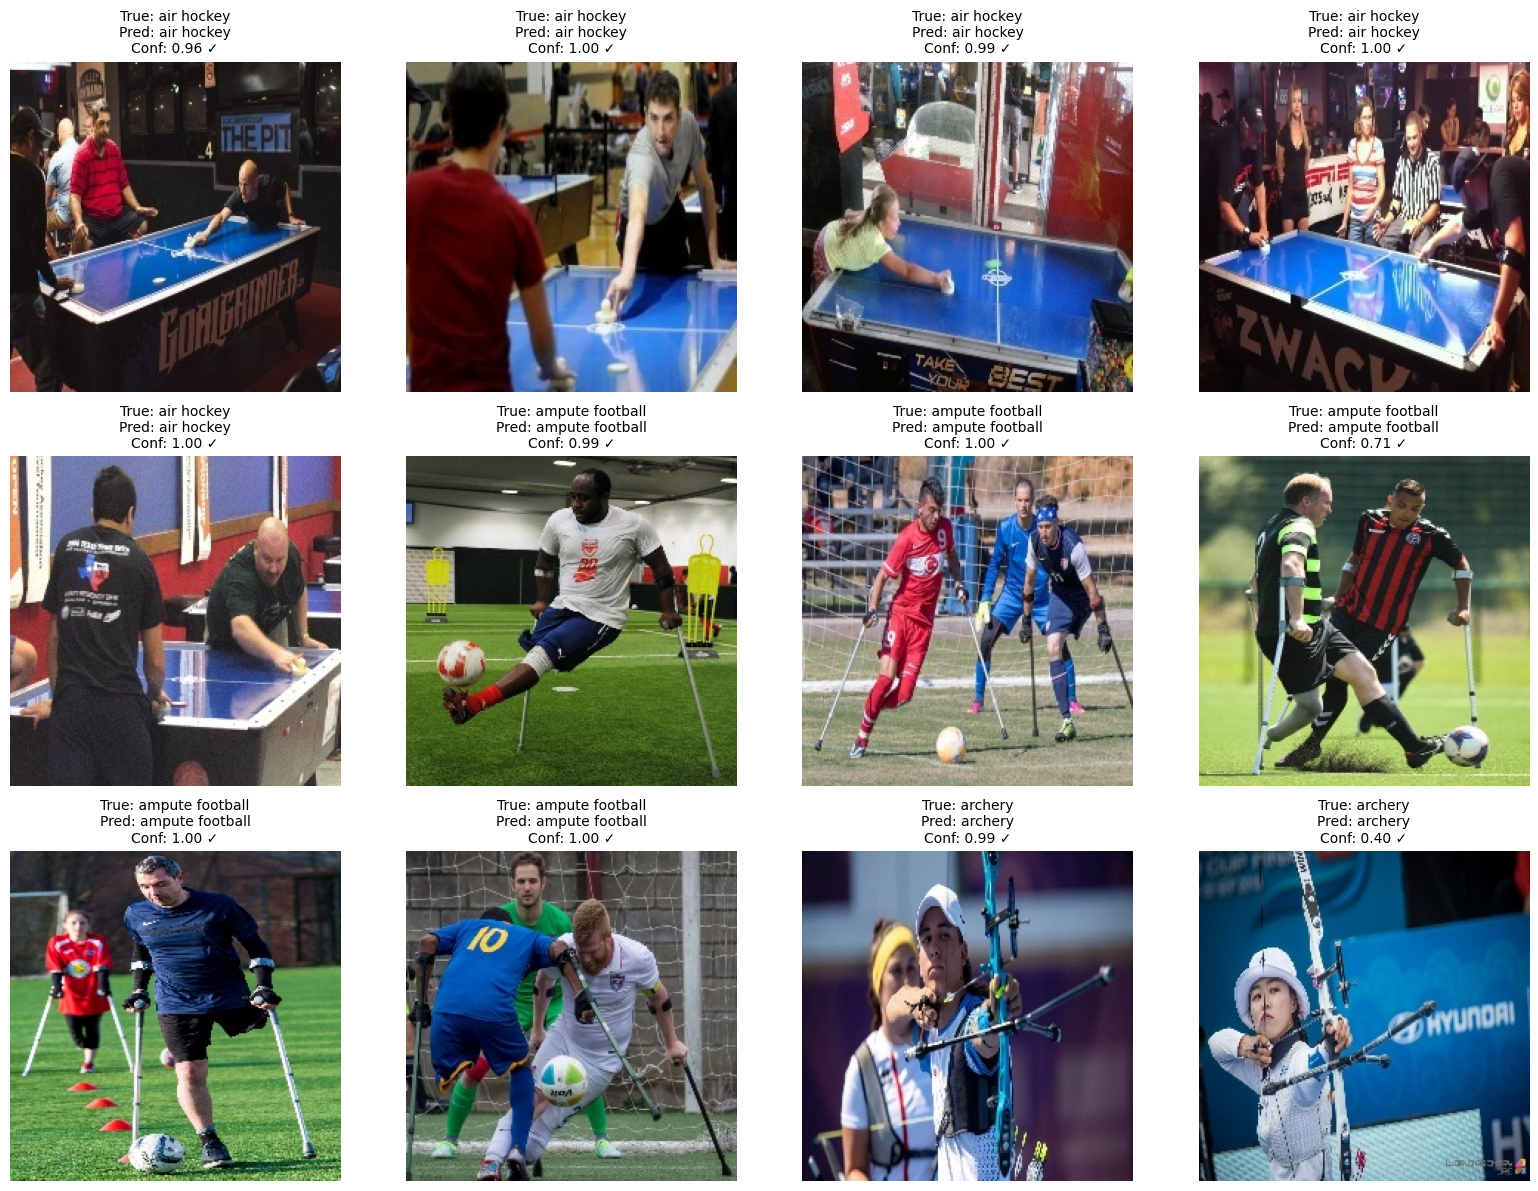

Визуализировано изображений: 12
Правильных предсказаний: 12 (100.0%)
Неправильных предсказаний: 0 (0.0%)

Выводы:
- Визуализация позволяет увидеть, на каких изображениях модель ошибается
- Высокая уверенность (confidence) в неправильных предсказаниях может указывать на проблемы с данными
- Частые ошибки между определенными классами могут требовать дополнительных данных или аугментаций


In [11]:
# Визуализация предсказаний на валидационной выборке
if 'model' in globals() and model is not None:
    model.eval()
    
    # Получаем батч изображений
    data_iter = iter(val_loader)
    images, labels = next(data_iter)
    images = images.to(device)
    
    # Делаем предсказания
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
    
    # Денормализация для визуализации
    def denormalize(tensor, mean, std):
        """Денормализует тензор изображения"""
        mean_tensor = torch.tensor(mean).view(3, 1, 1)
        std_tensor = torch.tensor(std).view(3, 1, 1)
        return tensor * std_tensor + mean_tensor
    
    # Визуализируем результаты
    num_images = min(12, len(images))
    cols = 4
    rows = (num_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx in range(num_images):
        row, col = idx // cols, idx % cols
        
        # Денормализуем изображение
        img = images[idx].cpu().clone()
        img = denormalize(img, mean, std)
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0).numpy()
        
        # Получаем предсказание и истинный класс
        # Используем классы из датасета (они отсортированы одинаково)
        pred_class = val_dataset.classes[preds[idx].item()]
        true_class = val_dataset.classes[labels[idx].item()]
        confidence = probs[idx][preds[idx]].item()
        is_correct = preds[idx].item() == labels[idx].item()
        
        axes[row, col].imshow(img)
        title = f"True: {true_class}\nPred: {pred_class}\n"
        title += f"Conf: {confidence:.2f} "
        title += "✓" if is_correct else "✗"
        axes[row, col].set_title(title, fontsize=10)
        axes[row, col].axis('off')
        
        # Подсвечиваем неправильные предсказания
        if not is_correct:
            for spine in axes[row, col].spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)
    
    # Скрываем лишние subplots
    for idx in range(num_images, rows * cols):
        row, col = idx // cols, idx % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Статистика по визуализированным изображениям
    correct_count = sum(1 for i in range(num_images) if preds[i].item() == labels[i].item())
    print(f"Визуализировано изображений: {num_images}")
    print(f"Правильных предсказаний: {correct_count} ({100*correct_count/num_images:.1f}%)")
    print(f"Неправильных предсказаний: {num_images - correct_count} ({100*(num_images-correct_count)/num_images:.1f}%)")
    
    print("\nВыводы:")
    print("- Визуализация позволяет увидеть, на каких изображениях модель ошибается")
    print("- Высокая уверенность (confidence) в неправильных предсказаниях может указывать на проблемы с данными")
    print("- Частые ошибки между определенными классами могут требовать дополнительных данных или аугментаций")
else:
    print("Сначала обучите модель")
